**Examining the effect of number of layer - Arhitecture with 4 Layers**

In this notebook, the encoder and decoder, both with 4 layers, are created to examine the effect of number of layers, while the latent space dimension is fixed to 16.

In [1]:
# Import the modules necessary
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import PIL.Image
import keras.backend as K
import glob, os
import random
from PIL import Image as Im

2023-08-13 01:24:17.516442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Load data from image files (Starting with 1000 pictures)

In [2]:
# Get the parent directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get the grandparent directory
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))

# Construct the path to the 'data' folder
data_folder_path = os.path.join(grandparent_directory, 'data', 'datav64')

In [3]:
# The folder name for the pictures supplied
foldername=data_folder_path

# Number of pictures to work with
number_of_pics = 1000

# Create an counter to stop the for loop below when # number_of_pics is reached
counter = 0

# Create an empty list to store the name of pictures so that we can know which pics we are using
sample_pics_names = [0] * number_of_pics

# Create an empty array to store pictures (image size is 64 x 64 x 4 but channel number will be changed to 3)
sample_pics = np.empty((number_of_pics,64,64,3))

# adding images as arrays to the negative_image_arrays
index = 0
for images in os.listdir(foldername):
    if images.endswith(".png"):
        # get the individual image path
        image_path = os.path.join(foldername,images)
        # open the image
        img = Im.open(image_path)
        # get it as an array 
        img_array = np.array(img)
        # Getting rid of the alpha channel
        img_array = img_array[:, :,:3]
        # Normalization of the array 
        new_img = (img_array - np.min(img_array)) / (np.max(img_array)-np.min(img_array))
        # Returning it back to array
        normalized_img_array= np.array(new_img)
        # adding it to the arrays
        sample_pics_names[counter] = str(images)
        sample_pics[counter,:,:,:] = normalized_img_array 
        # increasing the counter
        counter += 1
    if counter == number_of_pics: 
        break
        
# Check how many pics that we stored in the lists
print("Number of sample pictures that are used:", len(sample_pics_names))
# Check whether the matplotlib.image.imread yields arrays indeed... 
print("The matplotlib.image.imread function yields: ", type(sample_pics[0]))
# Check the size of the array after reading it with matplotlib.image.imread 
image_shape = sample_pics[0].shape
print("The shape of the array for the images: ", image_shape)

Number of sample pictures that are used: 1000
The matplotlib.image.imread function yields:  <class 'numpy.ndarray'>
The shape of the array for the images:  (64, 64, 3)


In [4]:
# Create a tensorflow dataset 
batch_size = 64 # pictures will be batched by size of 64 (except the last batch)
# Each element in the array corresponds to one element using from_tensor_slices
dataset = tf.data.Dataset.from_tensor_slices(sample_pics).batch(batch_size).shuffle(132) 
# Shuffle function providing a diverse and randomized order of elements 

2023-08-13 01:24:37.452659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2. Build the Autoencoder**

In [5]:
# Firstly, create the Encoder whose output is mean and log-variance

# Define the size of latent space dimension
latent_space_dimension = 16

# Start with the Input layer (encoder_inputs) whose size is image_shape (64,64,3) 
encoder_inputs = layers.Input(shape = (64,64,3))

# Applying some filters, pooling etc. 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), activation = 'relu', padding = 'same')(encoder_inputs) # Input is encoder_inputs
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Flatten()(x) # Flattening the network to go from Conv2D to 1D space

# Creating 2 Dense layers after flattening to represent mean and log-variance of the network created above
# Both of them connected to the same flattened layer
mean = layers.Dense(latent_space_dimension)(x) 
log_var = layers.Dense(latent_space_dimension)(x)

In [6]:
# Creating a layer named as Sampling whose function is to get the mean and log variance from the encoder 
# and then creating a random noise epsilon, and finally return z (output of the sampling)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs;
        batch_size = tf.shape(z_mean)[0]
        dimension = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch_size, dimension))
        return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [7]:
# Connecting the Encoder with Sampling Layer
output_sampling = Sampling()([mean, log_var])
encoder = tf.keras.Model(encoder_inputs, [mean,log_var,output_sampling],name = "Encoder_Architecture")
encoder.summary()

Model: "Encoder_Architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                               

In [8]:
# Create the decoder (the input shape to the decoder is the shape of latent space)
decoder_inputs = layers.Input(shape = (latent_space_dimension,))

# Very Similar decoder architecture is used as the Practice 9 here... 
# The difference is that we should have an output size 64 x 64 x 3
# I.e., At the end 1 more UpSampling2D && filters = 3... 
x = layers.Dense(8*8*8, activation = 'relu')(decoder_inputs)
x = layers.Reshape((8,8,8))(x)
x = layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling2D()(x) 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(filters = 3, kernel_size = (2,2), padding = 'same')(x) # 3 channels
decoder = tf.keras.Model(decoder_inputs, x, name = "Decoder_Architecture") 
decoder.summary()

Model: "Decoder_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 512)               8704      
                                                                 
 reshape (Reshape)           (None, 8, 8, 8)           0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         4224      
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 128)         0         
                                              

In [9]:
# Combine the whole architecture encoder & decoder 
inp = encoder.input
out = encoder.output
decoder_output = decoder(out[2])
vae = tf.keras.Model(inp, decoder_output,name="4LayersArchitecture")
vae.summary()

Model: "4LayersArchitecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                

**3. Define the Loss Function**

In [10]:
# define loss functions
def kl_loss(z_log_var,z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return kl_loss * 0.012

loss = tf.keras.losses.BinaryCrossentropy()
def reconstruction_loss(data,reconstructed):
    return loss(data,reconstructed)

optimizer = tf.keras.optimizers.Adam()  

In [11]:
# Train model using GRADIENT TAPE
def train_steps(data):
    total_loss = 0
    with tf.GradientTape() as vae_tape:
        z_mean,z_log_var,z = encoder(data)
        reconstructed_image = decoder(z)
        kl_ = kl_loss(z_log_var,z_mean)
        reconstruction_ = reconstruction_loss(data, reconstructed_image)
        total_loss = kl_ + reconstruction_

    gradient2 = vae_tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradient2, vae.trainable_variables))
    return total_loss

In [12]:
%matplotlib inline
# visualize results from epoch 
noise = tf.keras.backend.random_normal(shape = (9,latent_space_dimension))
def visualize(epoch):
        prediction = decoder(noise)
        plt.figure(figsize = (5,5))
        for i in range(9):
            if(i == 2):
                plt.title("Epoch: {}".format(epoch))
            plt.subplot(3,3,i+1)
            plt.imshow(prediction[i],cmap = 'gray')
            plt.axis('off')
            # Save the plot to the generated folder
            file_path = os.path.join('generated', 'generated_plot_epoch_{}.png'.format(epoch))
            plt.savefig(file_path)

In [13]:
# create training function
def train(dataset,epochs,start_epoch=0):

    loss_history = [] # To store loss values for each epoch

    for epoch in range(epochs):
        start = time.time()
        epoch_losses = []  # To store loss values for each batch in the epoch

        for batch in dataset:
            total_loss = train_steps(batch)
            # Append the mean of total_loss for each batch
            epoch_losses.append(np.sum(total_loss)/(total_loss.shape[0] * total_loss.shape[1]))
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) # Calculate the average loss for the epoch
        loss_history.append(avg_epoch_loss)  # Store the average loss in the loss_history list

        print("Epoch: {} Time: {} Avg Loss: {}".format(epoch+1, np.round(time.time()-start, 2), avg_epoch_loss))

        if epoch % 10 == 0:
            visualize(epoch+1+start_epoch)
        
    return loss_history  # Return the list of average epoch losses



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 Time: 8.44 Avg Loss: 1.682636772841215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 Time: 8.21 Avg Loss: 0.7493707194924355
Epoch: 3 Time: 7.41 Avg Loss: 0.7310643509030342
Epoch: 4 Time: 7.44 Avg Loss: 0.7201129756867886
Epoch: 5 Time: 7.36 Avg Loss: 0.711095355451107
Epoch: 6 Time: 7.41 Avg Loss: 0.7052830286324024
Epoch: 7 Time: 7.39 Avg Loss: 0.7005556158721447
Epoch: 8 Time: 7.35 Avg Loss: 0.6970176436007023
Epoch: 9 Time: 7.36 Avg Loss: 0.6948501631617546
Epoch: 10 Time: 7.03 Avg Loss: 0.6932513259351254
Epoch: 11 Time: 8.11 Avg Loss: 0.6915090143680572
Epoch: 12 Time: 7.27 Avg Loss: 0.6906202040612698
Epoch: 13 Time: 7.09 Avg Loss: 0.6898306459188461
Epoch: 14 Time: 6.95 Avg Loss: 0.6891244240105152
Epoch: 15 Time: 6.93 Avg Loss: 0.6885646410286427
Epoch: 16 Time: 6.81 Avg Loss: 0.6881501972675323
Epoch: 17 Time: 6.92 Avg Loss: 0.6878053575754166
Epoch: 18 Time: 6.92 Avg Loss: 0.6874597899615764
Epoch: 19 Time: 6.96 Avg Loss: 0.6872415862977505
Epoch: 20 Time: 6.9 Avg Loss: 0.6870812125504017
Epoch: 21 Time: 6.95 Avg Loss: 0.6868696734309196
Epoch: 22 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 52 Time: 7.0 Avg Loss: 0.6379298463463783
Epoch: 53 Time: 7.05 Avg Loss: 0.635572549700737
Epoch: 54 Time: 7.01 Avg Loss: 0.634516866505146
Epoch: 55 Time: 7.07 Avg Loss: 0.6337802350521088
Epoch: 56 Time: 7.02 Avg Loss: 0.6328059554100036
Epoch: 57 Time: 7.04 Avg Loss: 0.6325186960399151
Epoch: 58 Time: 6.99 Avg Loss: 0.6318055972456932
Epoch: 59 Time: 7.05 Avg Loss: 0.631219332665205
Epoch: 60 Time: 7.0 Avg Loss: 0.6305757030844689
Epoch: 61 Time: 6.97 Avg Loss: 0.6304821699857712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 62 Time: 7.12 Avg Loss: 0.6295280419290066
Epoch: 63 Time: 6.97 Avg Loss: 0.6289127953350544
Epoch: 64 Time: 7.08 Avg Loss: 0.6288013212382794
Epoch: 65 Time: 6.95 Avg Loss: 0.6290774933993817
Epoch: 66 Time: 7.17 Avg Loss: 0.628462640196085
Epoch: 67 Time: 7.27 Avg Loss: 0.6281622372567653
Epoch: 68 Time: 7.34 Avg Loss: 0.6274909041821957
Epoch: 69 Time: 7.69 Avg Loss: 0.6273405313491821
Epoch: 70 Time: 8.19 Avg Loss: 0.6283341355621814
Epoch: 71 Time: 7.63 Avg Loss: 0.6268481701612473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 72 Time: 7.38 Avg Loss: 0.6267142087221146
Epoch: 73 Time: 6.91 Avg Loss: 0.6261222004890442
Epoch: 74 Time: 6.97 Avg Loss: 0.6260071091353894
Epoch: 75 Time: 6.89 Avg Loss: 0.6260377287864685
Epoch: 76 Time: 6.92 Avg Loss: 0.6256733641028405
Epoch: 77 Time: 6.98 Avg Loss: 0.6255004115402698
Epoch: 78 Time: 6.91 Avg Loss: 0.6252704545855522
Epoch: 79 Time: 6.9 Avg Loss: 0.6247653476893902
Epoch: 80 Time: 6.98 Avg Loss: 0.6244991704821586
Epoch: 81 Time: 6.91 Avg Loss: 0.6242591813206673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 82 Time: 6.99 Avg Loss: 0.6241058900952339
Epoch: 83 Time: 6.95 Avg Loss: 0.6241086885333061
Epoch: 84 Time: 6.92 Avg Loss: 0.623975633084774
Epoch: 85 Time: 6.95 Avg Loss: 0.6262925818562508
Epoch: 86 Time: 6.94 Avg Loss: 0.6250361189246177
Epoch: 87 Time: 6.96 Avg Loss: 0.6238344825804234
Epoch: 88 Time: 6.91 Avg Loss: 0.6256197065114975
Epoch: 89 Time: 6.98 Avg Loss: 0.6257989250123501
Epoch: 90 Time: 7.0 Avg Loss: 0.6233244232833386
Epoch: 91 Time: 6.89 Avg Loss: 0.6223135247826577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 92 Time: 7.02 Avg Loss: 0.6222369752824306
Epoch: 93 Time: 6.91 Avg Loss: 0.6218732133507728
Epoch: 94 Time: 6.89 Avg Loss: 0.6223463110625744
Epoch: 95 Time: 6.96 Avg Loss: 0.6224816910922527
Epoch: 96 Time: 6.96 Avg Loss: 0.6217345342040062
Epoch: 97 Time: 7.04 Avg Loss: 0.6212169647216796
Epoch: 98 Time: 7.03 Avg Loss: 0.6210199877619743
Epoch: 99 Time: 7.09 Avg Loss: 0.6208927989006042
Epoch: 100 Time: 6.96 Avg Loss: 0.6202864468097686
Epoch: 101 Time: 6.95 Avg Loss: 0.6203783504664898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 102 Time: 7.04 Avg Loss: 0.6208543218672276
Epoch: 103 Time: 6.98 Avg Loss: 0.6199585691094398
Epoch: 104 Time: 7.04 Avg Loss: 0.6193456344306469
Epoch: 105 Time: 6.95 Avg Loss: 0.6195193193852901
Epoch: 106 Time: 7.0 Avg Loss: 0.6189981333911418
Epoch: 107 Time: 6.99 Avg Loss: 0.6186879426240921
Epoch: 108 Time: 6.95 Avg Loss: 0.618779031932354
Epoch: 109 Time: 7.4 Avg Loss: 0.6182073824107647
Epoch: 110 Time: 7.67 Avg Loss: 0.6182886116206646
Epoch: 111 Time: 7.54 Avg Loss: 0.6189362466335296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 112 Time: 7.28 Avg Loss: 0.6183261178433895
Epoch: 113 Time: 7.35 Avg Loss: 0.6178760305047035
Epoch: 114 Time: 7.46 Avg Loss: 0.6175579272210598
Epoch: 115 Time: 7.12 Avg Loss: 0.6171851515769958
Epoch: 116 Time: 7.11 Avg Loss: 0.6196485564112664
Epoch: 117 Time: 7.14 Avg Loss: 0.6212926730513573
Epoch: 118 Time: 7.67 Avg Loss: 0.6182895429432392
Epoch: 119 Time: 7.54 Avg Loss: 0.6173302069306373
Epoch: 120 Time: 7.17 Avg Loss: 0.6171857453882694
Epoch: 121 Time: 7.17 Avg Loss: 0.623297405987978


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 122 Time: 7.13 Avg Loss: 0.6243781588971615
Epoch: 123 Time: 7.16 Avg Loss: 0.6184761628508568
Epoch: 124 Time: 7.01 Avg Loss: 0.6182092323899269
Epoch: 125 Time: 7.14 Avg Loss: 0.6165744997560978
Epoch: 126 Time: 7.15 Avg Loss: 0.6160430856049061
Epoch: 127 Time: 7.43 Avg Loss: 0.6168442606925965
Epoch: 128 Time: 7.45 Avg Loss: 0.6158143244683743
Epoch: 129 Time: 7.07 Avg Loss: 0.6155017793178559
Epoch: 130 Time: 6.93 Avg Loss: 0.6153157576918602
Epoch: 131 Time: 7.03 Avg Loss: 0.6153062358498573
Epoch: 132 Time: 7.06 Avg Loss: 0.6146881833672524
Epoch: 133 Time: 7.2 Avg Loss: 0.615573837608099
Epoch: 134 Time: 7.19 Avg Loss: 0.6141972206532955
Epoch: 135 Time: 7.25 Avg Loss: 0.61381034553051
Epoch: 136 Time: 7.09 Avg Loss: 0.6143728241324424
Epoch: 137 Time: 7.59 Avg Loss: 0.6135735884308815
Epoch: 138 Time: 7.26 Avg Loss: 0.6139508925378323
Epoch: 139 Time: 7.3 Avg Loss: 0.6137936756014823
Epoch: 140 Time: 7.34 Avg Loss: 0.6134837493300438
Epoch: 141 Time: 7.26 Avg Loss: 0.61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 142 Time: 7.2 Avg Loss: 0.6139448866248131
Epoch: 143 Time: 7.13 Avg Loss: 0.6131277158856392
Epoch: 144 Time: 7.62 Avg Loss: 0.6128274939954281
Epoch: 145 Time: 7.12 Avg Loss: 0.6130019508302211
Epoch: 146 Time: 7.03 Avg Loss: 0.6124901451170445
Epoch: 147 Time: 7.08 Avg Loss: 0.6122312493622303
Epoch: 148 Time: 7.08 Avg Loss: 0.6124093480408191
Epoch: 149 Time: 7.12 Avg Loss: 0.6120203115046025
Epoch: 150 Time: 7.6 Avg Loss: 0.6135927639901638
Epoch: 151 Time: 7.55 Avg Loss: 0.6128394089639186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


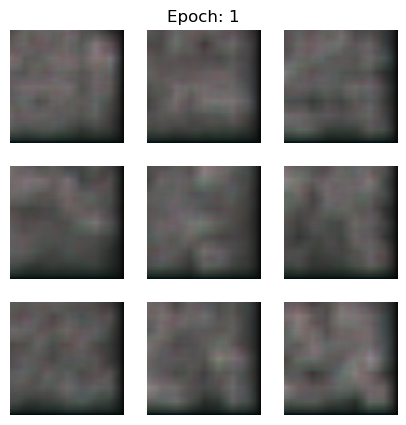

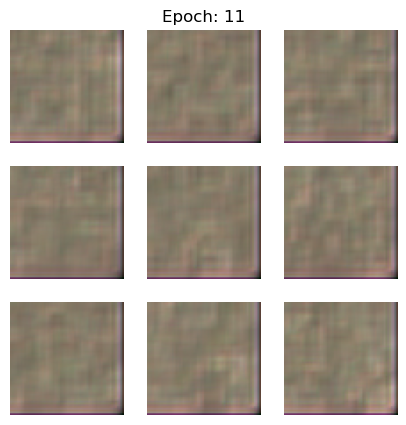

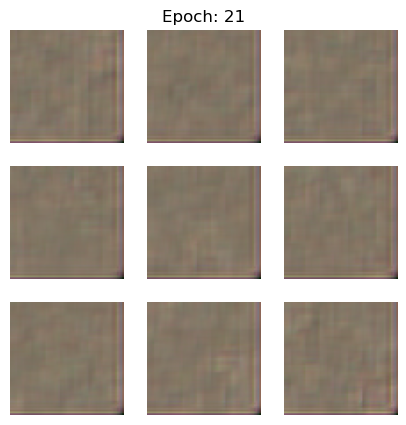

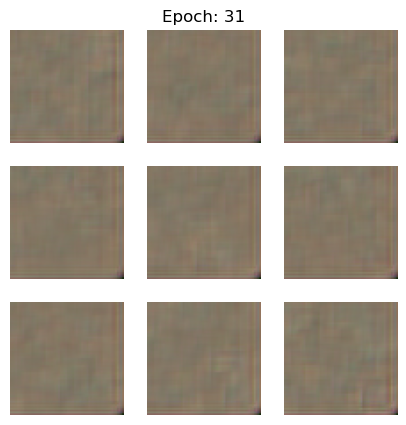

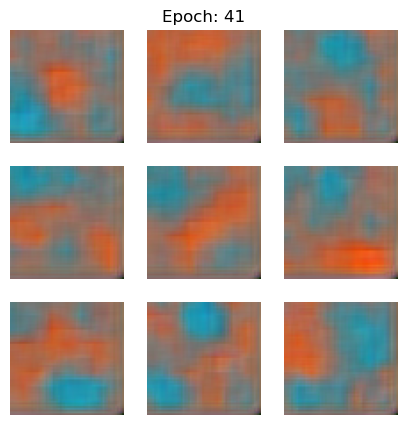

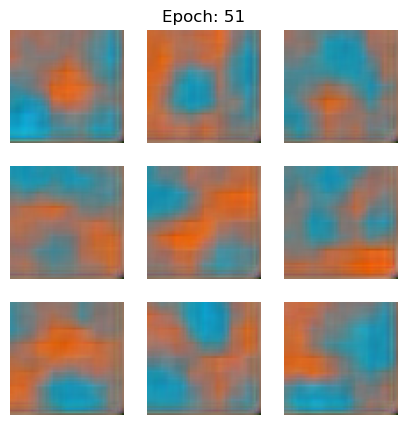

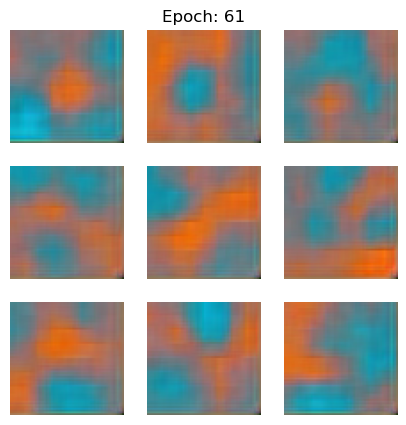

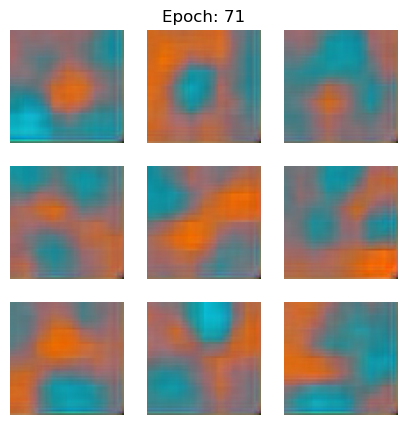

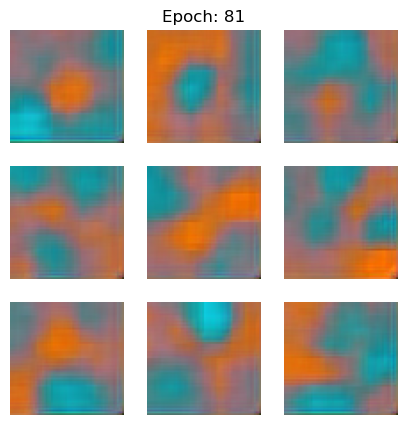

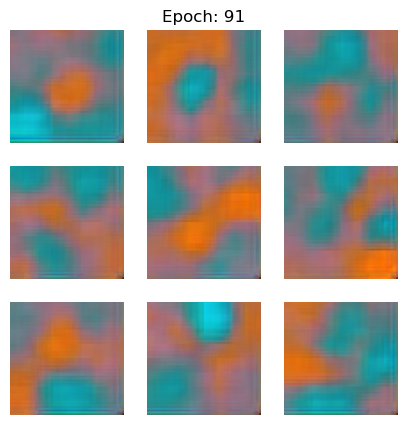

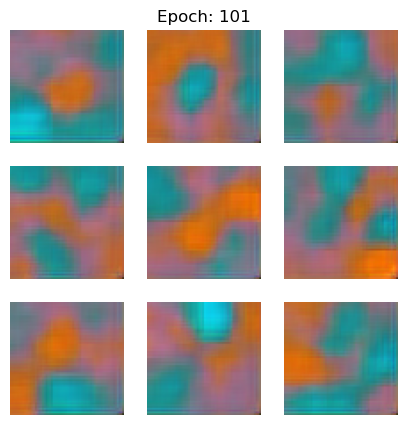

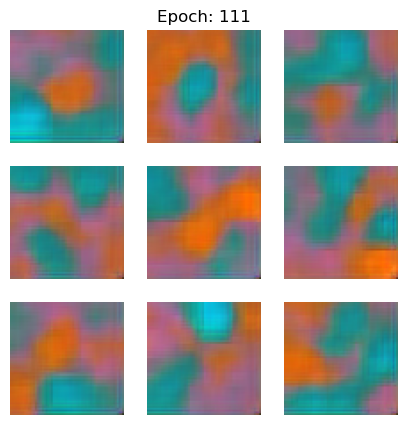

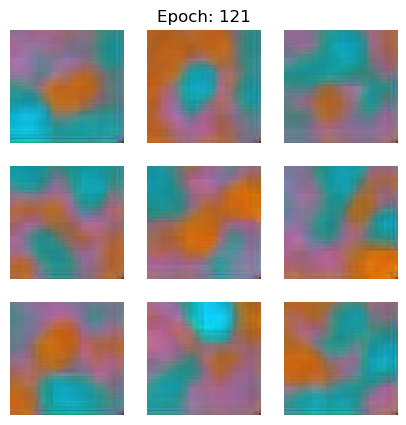

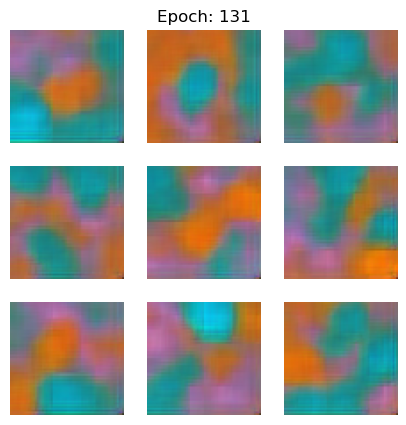

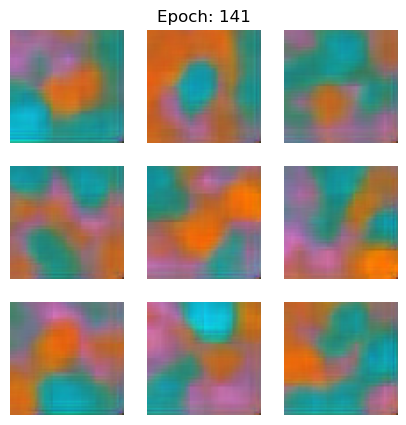

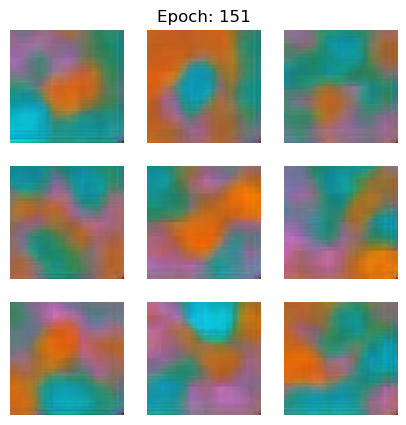

In [14]:
%matplotlib inline
# Train the data set
epochs = 151
architecture_loss_history = train(dataset,epochs=epochs,start_epoch=0)
# Save the weights
generated_weights_folder = os.path.join(os.getcwd(),'weights')
vae.save_weights(os.path.join(generated_weights_folder, f'weights_for_4_layers'))

In [16]:
# Saving sample_pics to use it in another architectures so that we have the same input pictures
import pickle

with open('sample_pics.pkl', 'wb') as f:
    pickle.dump(sample_pics, f)

In [17]:
# Saving architecture_loss_history to compare it with other architectures
with open('architecture_loss_history_4_layers.pkl', 'wb') as f:
    pickle.dump(architecture_loss_history, f)